In [2]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import TomekLinks

from imblearn.pipeline import Pipeline

# 모델
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# 모델 평가 
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, 
                             auc, precision_recall_curve, accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix)

from sklearn.model_selection import learning_curve

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from matplotlib import rc
%matplotlib inline
rc('font', family='Arial Unicode MS')

# 1. 데이터 준비

In [3]:
data = pd.read_csv('./CVD_cleaned.csv')

#data.loc[(data['Age_Category']=='18-24') | (data['Age_Category']=='25-29'), 'Age_Category'] = '18-29'
#data.loc[(data['Age_Category']=='30-34') | (data['Age_Category']=='35-39'), 'Age_Category'] = '30-39'
#data.loc[(data['Age_Category']=='40-44') | (data['Age_Category']=='45-49'), 'Age_Category'] = '40-49'
#data.loc[(data['Age_Category']=='50-54') | (data['Age_Category']=='55-59'), 'Age_Category'] = '50-59'
#data.loc[(data['Age_Category']=='60-64') | (data['Age_Category']=='65-69'), 'Age_Category'] = '60-69'
#data.loc[(data['Age_Category']=='70-74') | (data['Age_Category']=='75-79'), 'Age_Category'] = '70-79'

# 추가 EDA
- decision tree는 bmi 카테코리화했을 때 성능이 더 좋음

In [6]:
data.columns

Index(['General_Health', 'Checkup', 'Exercise', 'Heart_Disease', 'Skin_Cancer',
       'Other_Cancer', 'Depression', 'Diabetes', 'Arthritis', 'Age_Category',
       'Height_(cm)', 'Weight_(kg)', 'BMI', 'Smoking_History',
       'Alcohol_Consumption', 'Fruit_Consumption',
       'Green_Vegetables_Consumption', 'FriedPotato_Consumption', 'Sex_Female',
       'Sex_Male'],
      dtype='object')

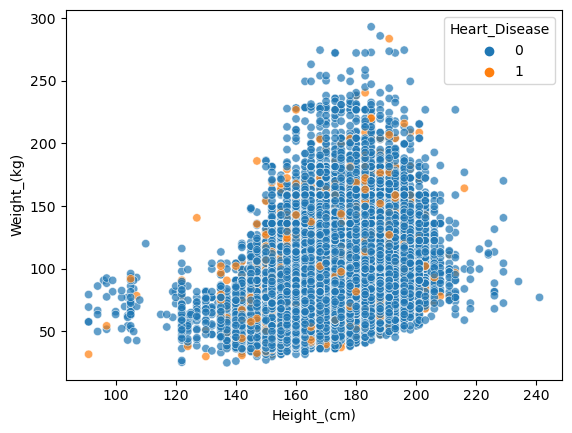

In [27]:
import seaborn as sns

data1 = data[['General_Health', 'Checkup', 'Exercise', 'Heart_Disease', 'Skin_Cancer', 'Other_Cancer', 'Depression', 'Diabetes']]
data2 = data[['Arthritis', 'Age_Category', 'Height_(cm)', 'Weight_(kg)', 'BMI', 'Smoking_History', 'Heart_Disease']]


sns.scatterplot(data=data, x='Height_(cm)', y='Weight_(kg)', hue='Heart_Disease', alpha=0.7);

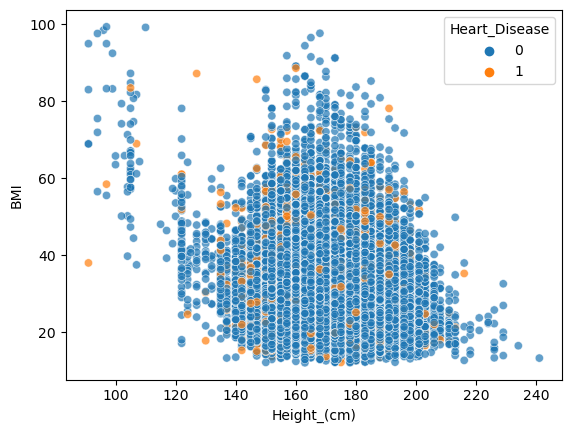

In [28]:
sns.scatterplot(data=data, x='Height_(cm)', y='BMI', hue='Heart_Disease', alpha=0.7);

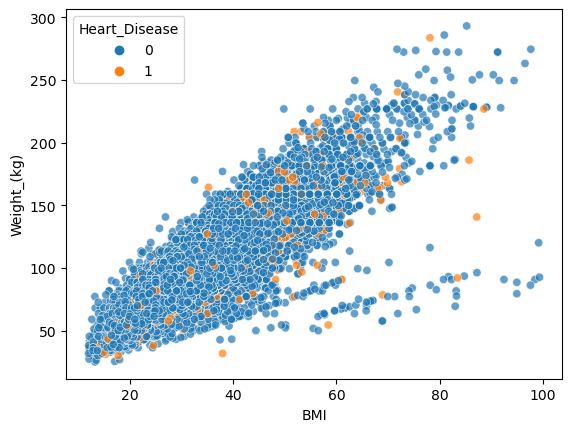

In [29]:
sns.scatterplot(data=data, x='BMI', y='Weight_(kg)', hue='Heart_Disease', alpha=0.7);

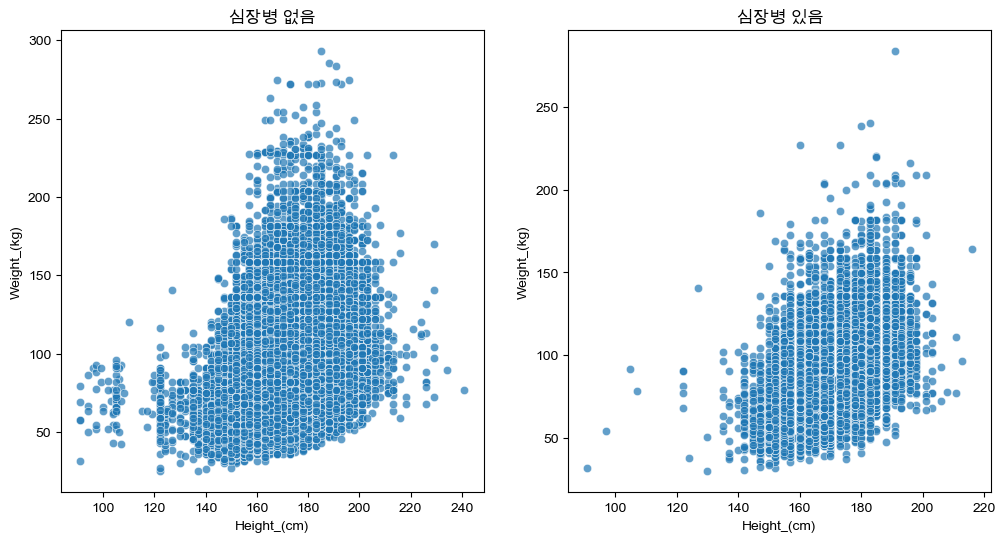

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.scatterplot(data=data, x='Height_(cm)', y='Weight_(kg)', alpha=0.7, ax=ax[0])
ax[0].set_title('심장병 없음')

sns.scatterplot(data=tmp, x='Height_(cm)', y='Weight_(kg)', alpha=0.7, ax=ax[1])
ax[1].set_title('심장병 있음')


plt.show()

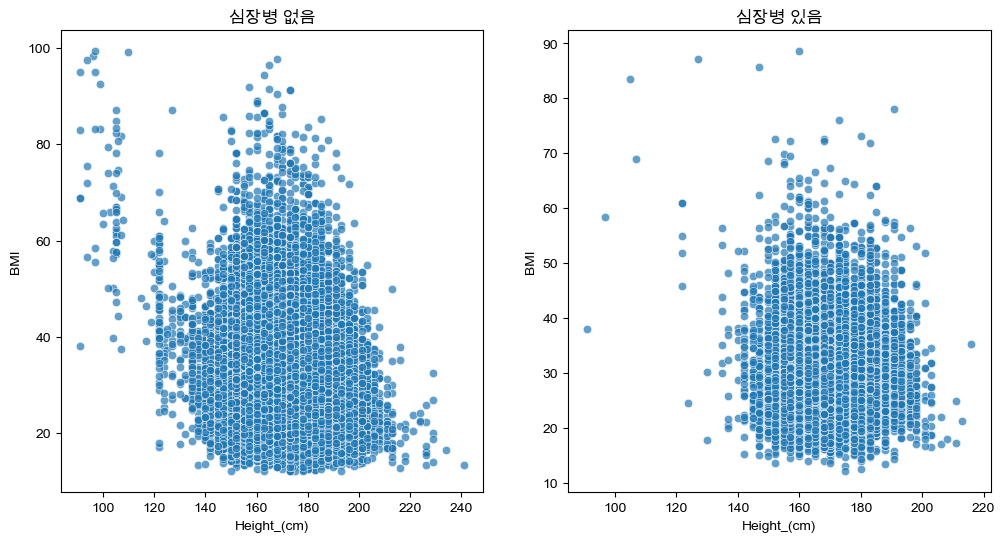

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.scatterplot(data=data, x='Height_(cm)', y='BMI', alpha=0.7, ax=ax[0])
ax[0].set_title('심장병 없음')

sns.scatterplot(data=tmp, x='Height_(cm)', y='BMI', alpha=0.7, ax=ax[1])
ax[1].set_title('심장병 있음')


plt.show()

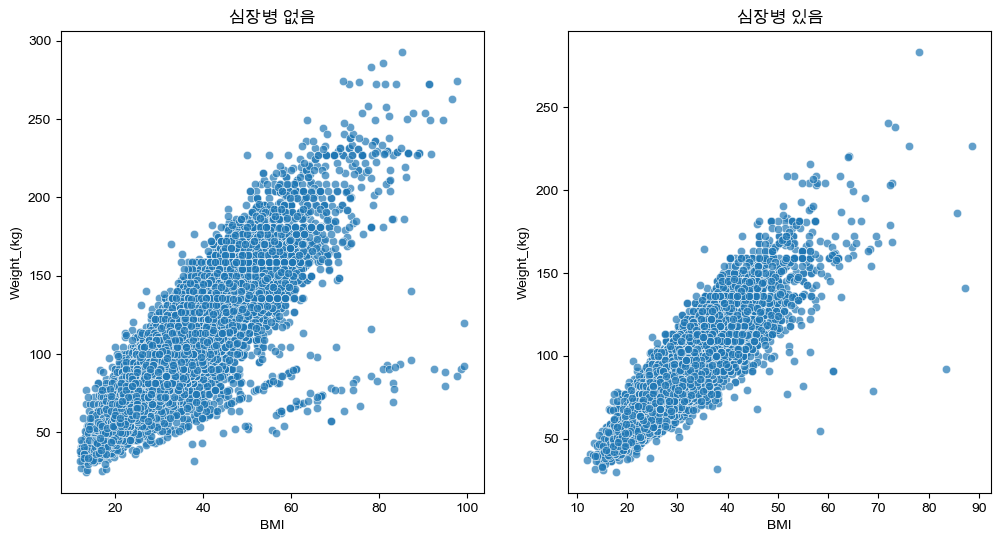

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.scatterplot(data=data, x='BMI', y='Weight_(kg)', alpha=0.7, ax=ax[0])
ax[0].set_title('심장병 없음')

sns.scatterplot(data=tmp, x='BMI', y='Weight_(kg)', alpha=0.7, ax=ax[1])
ax[1].set_title('심장병 있음')


plt.show()

심장병 있는 사람, 없는 사람 간 몸무게, 키, BMI 분포에서 큰 차이를 볼 수는 없다. 

#### meal column

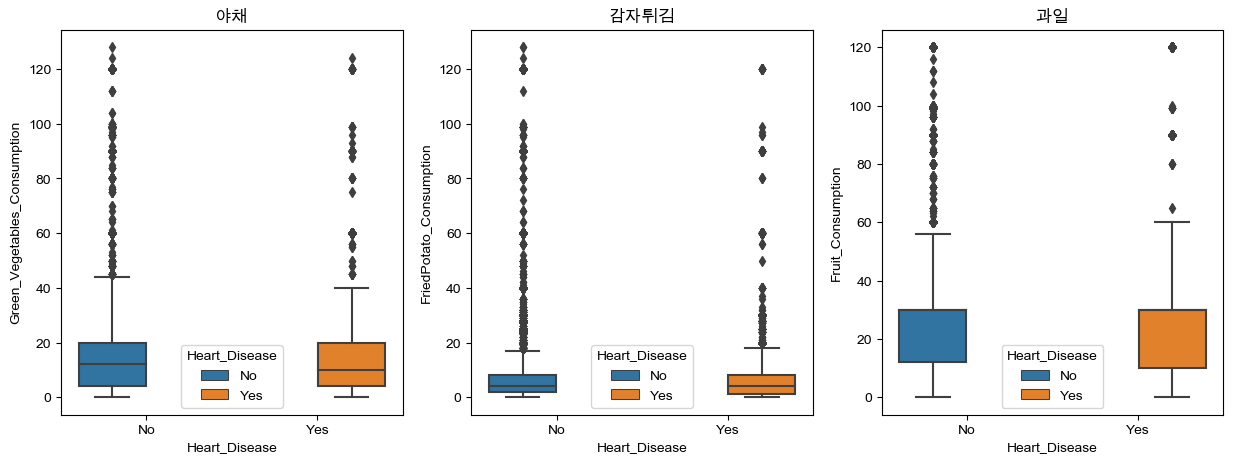

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

sns.boxplot(data=data, x='Heart_Disease', y='Green_Vegetables_Consumption', hue='Heart_Disease', ax=ax[0])
sns.boxplot(data=data, x='Heart_Disease', y='FriedPotato_Consumption', hue='Heart_Disease', ax=ax[1])
sns.boxplot(data=data, x='Heart_Disease', y='Fruit_Consumption', hue='Heart_Disease', ax=ax[2])

ax[0].set_title('야채')
ax[1].set_title('감자튀김')
ax[2].set_title('과일')

plt.show()

- 미세하게 야채 덜 먹고 감자튀김 더 많이 먹는 사람이 더 많이 심장병 걸리는듯 (중앙값으로 판단하면)
- 과일 소비는 육안으로 비교 어렵다

In [15]:
# 과일 소비는 육안으로 확인이 쉽지 않음
data.groupby('Heart_Disease')['Fruit_Consumption'].mean().to_frame()

,Fruit_Consumption
Heart_Disease,
No,29.983159
Yes,28.153138


확인해보니 심장병 있는 사람들이 평균적으로 약간 덜 먹기는 한다. 

In [36]:
datatmp = data.copy()
datatmp['meal'] =( data['Fruit_Consumption'] + data['Green_Vegetables_Consumption'] * 2 )- data['FriedPotato_Consumption']

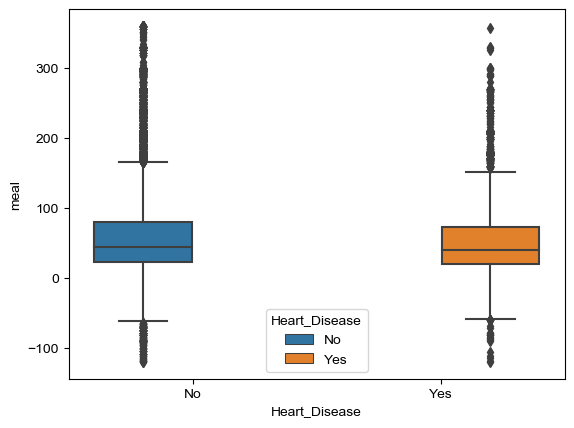

In [37]:
sns.boxplot(data=datatmp, x='Heart_Disease', y='meal', hue='Heart_Disease');

meal column을 추가해봤다. 

In [38]:
datatmp.groupby('Heart_Disease')['meal'].mean().to_frame()

,meal
Heart_Disease,
No,54.096811
Yes,49.924352


In [77]:
def binaryPie(df, target, color='tab10'):
    data1 = df[df[target]=='Yes']
    data2 = df[df[target]=='No']

    values1 = [len(data1[data1['Heart_Disease']=='No']), len(data1[data1['Heart_Disease']=='Yes'])]
    values2 = [len(data2[data2['Heart_Disease']=='No']), len(data2[data2['Heart_Disease']=='Yes'])]

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    colors = sns.color_palette(color)

    ax[0].pie(values1, labels=['심장병 없음', '심장병 있음'], autopct=lambda p: '{:.2f}%'.format(p), colors=colors)
    ax[1].pie(values2, labels=['심장병 없음', '심장병 있음'], autopct=lambda p: '{:.2f}%'.format(p), colors=colors)

    ax[0].set_title(f'{target} O')
    ax[1].set_title(f'{target} X')

    plt.show()

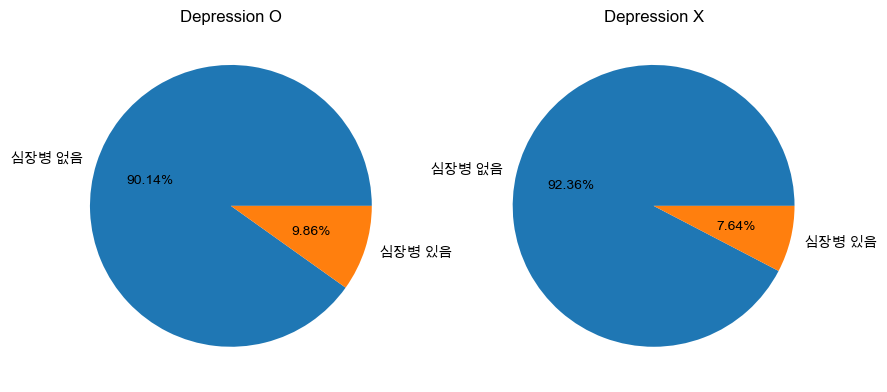

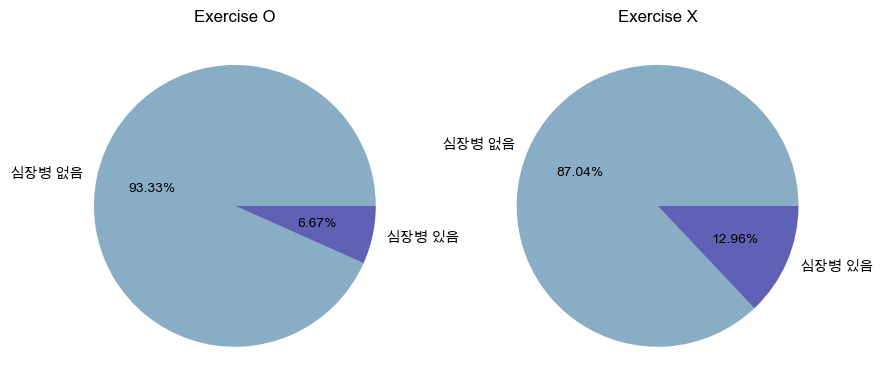

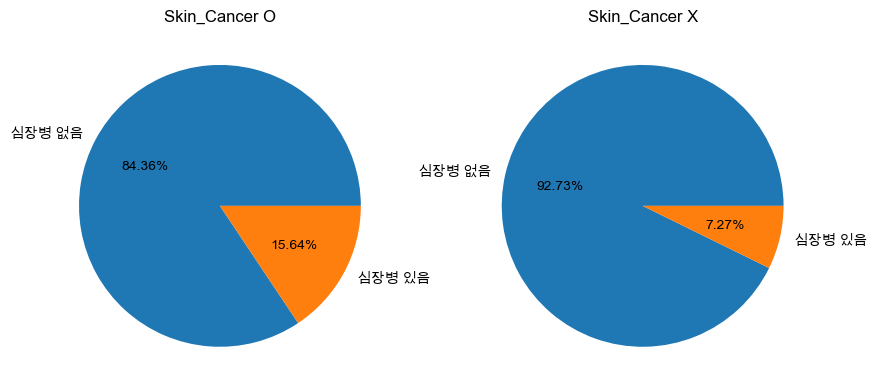

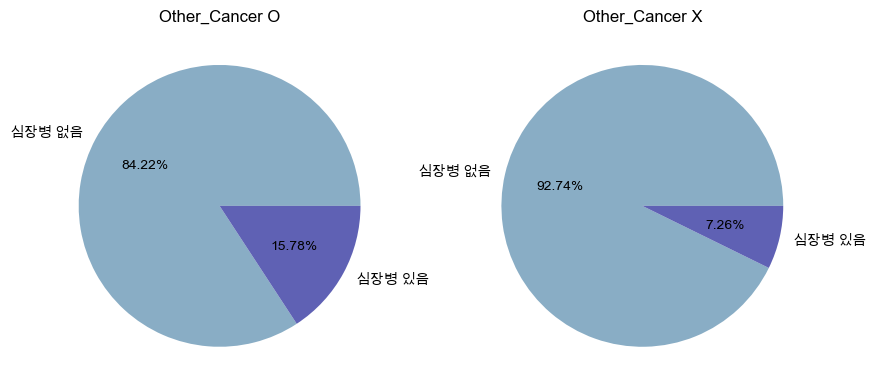

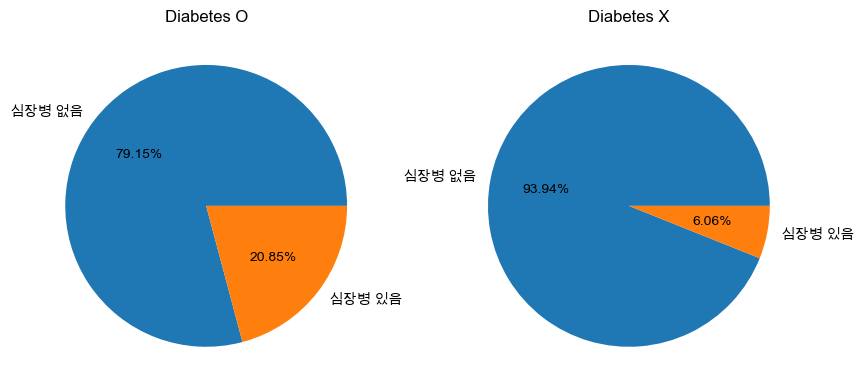

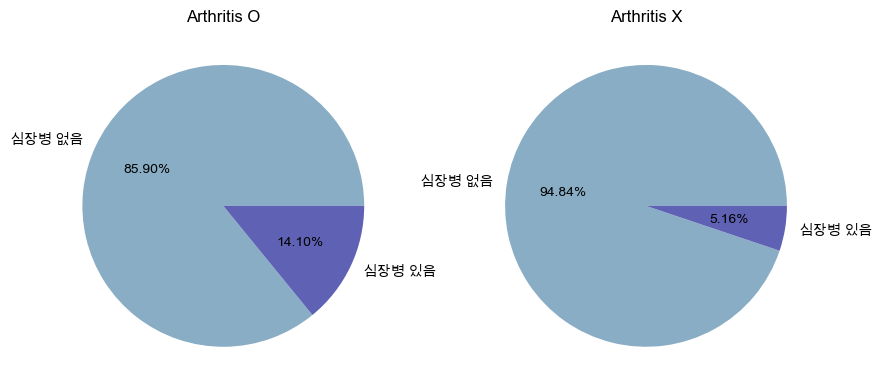

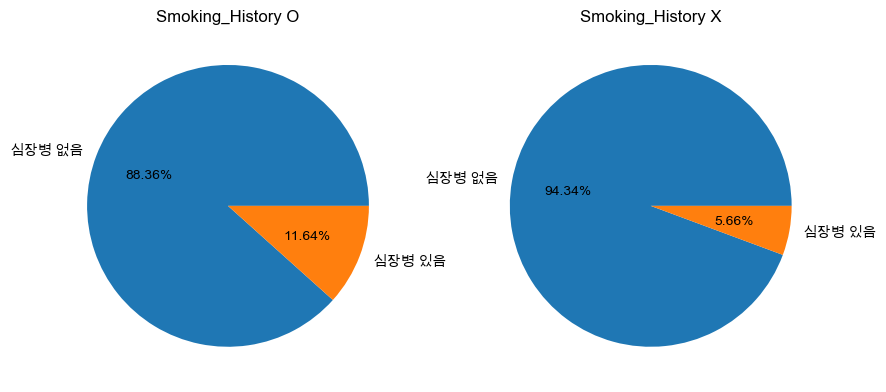

In [88]:
binaryPie(data, 'Depression', 'tab10')
binaryPie(data, 'Exercise', 'twilight')
binaryPie(data, 'Skin_Cancer', 'tab10')
binaryPie(data, 'Other_Cancer', 'twilight')
binaryPie(data, 'Diabetes', 'tab10')
binaryPie(data, 'Arthritis', 'twilight')
binaryPie(data, 'Smoking_History', 'tab10')

질병, 운동, 흡연 column들과 심장병 사이에 상관관계가 있어 보인다. 

In [ ]:
# 질병 column 아이디어
datatmp['disease'] = datatmp['Skin_Cancer'] + datatmp['Other_Cancer'] + datatmp['Diabetes'] * 2 + datatmp['Arthritis']